# Delivery time prediction


In [202]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin
from math import radians, sin, cos, sqrt, atan2
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pd.options.display.max_rows = 3

sys.path.append(
    "/Users/skronski/Documents/Projects/e_commerce/00_programs/00_project_setup"
)
from directories import directories_path_setup
from directories import update_gitignore
from directories import reading_files

#

directories = directories_path_setup(
    "e_commerce", "/Users/skronski/Documents/Projects/"
)
files_dict = reading_files(directories)

olist_sellers_dataset = files_dict["olist_sellers_dataset"]
product_category_name_translation = files_dict["product_category_name_translation"]
olist_orders_dataset = files_dict["olist_orders_dataset"]
olist_order_items_dataset = files_dict["olist_order_items_dataset"]
olist_customers_dataset = files_dict["olist_customers_dataset"]
olist_order_payments_dataset = files_dict["olist_order_payments_dataset"]
olist_order_reviews_dataset = files_dict["olist_order_reviews_dataset"]
olist_products_dataset = files_dict["olist_products_dataset"]
olist_geolocation_dataset = files_dict["olist_geolocation_dataset"]
olist_geolocation_dataset["geolocation_zip_code_prefix"] = olist_geolocation_dataset[
    "geolocation_zip_code_prefix"
].astype(int)
olist_customers_dataset["customer_zip_code_prefix"] = olist_customers_dataset[
    "customer_zip_code_prefix"
].astype(int)

The /Users/skronski/Documents/Projects/e_commerce/00_programs exists already.
The /Users/skronski/Documents/Projects/e_commerce/01_input exists already.
The /Users/skronski/Documents/Projects/e_commerce/02_output exists already.
The /Users/skronski/Documents/Projects/e_commerce/03_temporary exists already.
['/Users/skronski/Documents/Projects/e_commerce/01_input/olist_sellers_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/product_category_name_translation.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_orders_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_order_items_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_customers_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_geolocation_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_order_payments_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_order_reviews

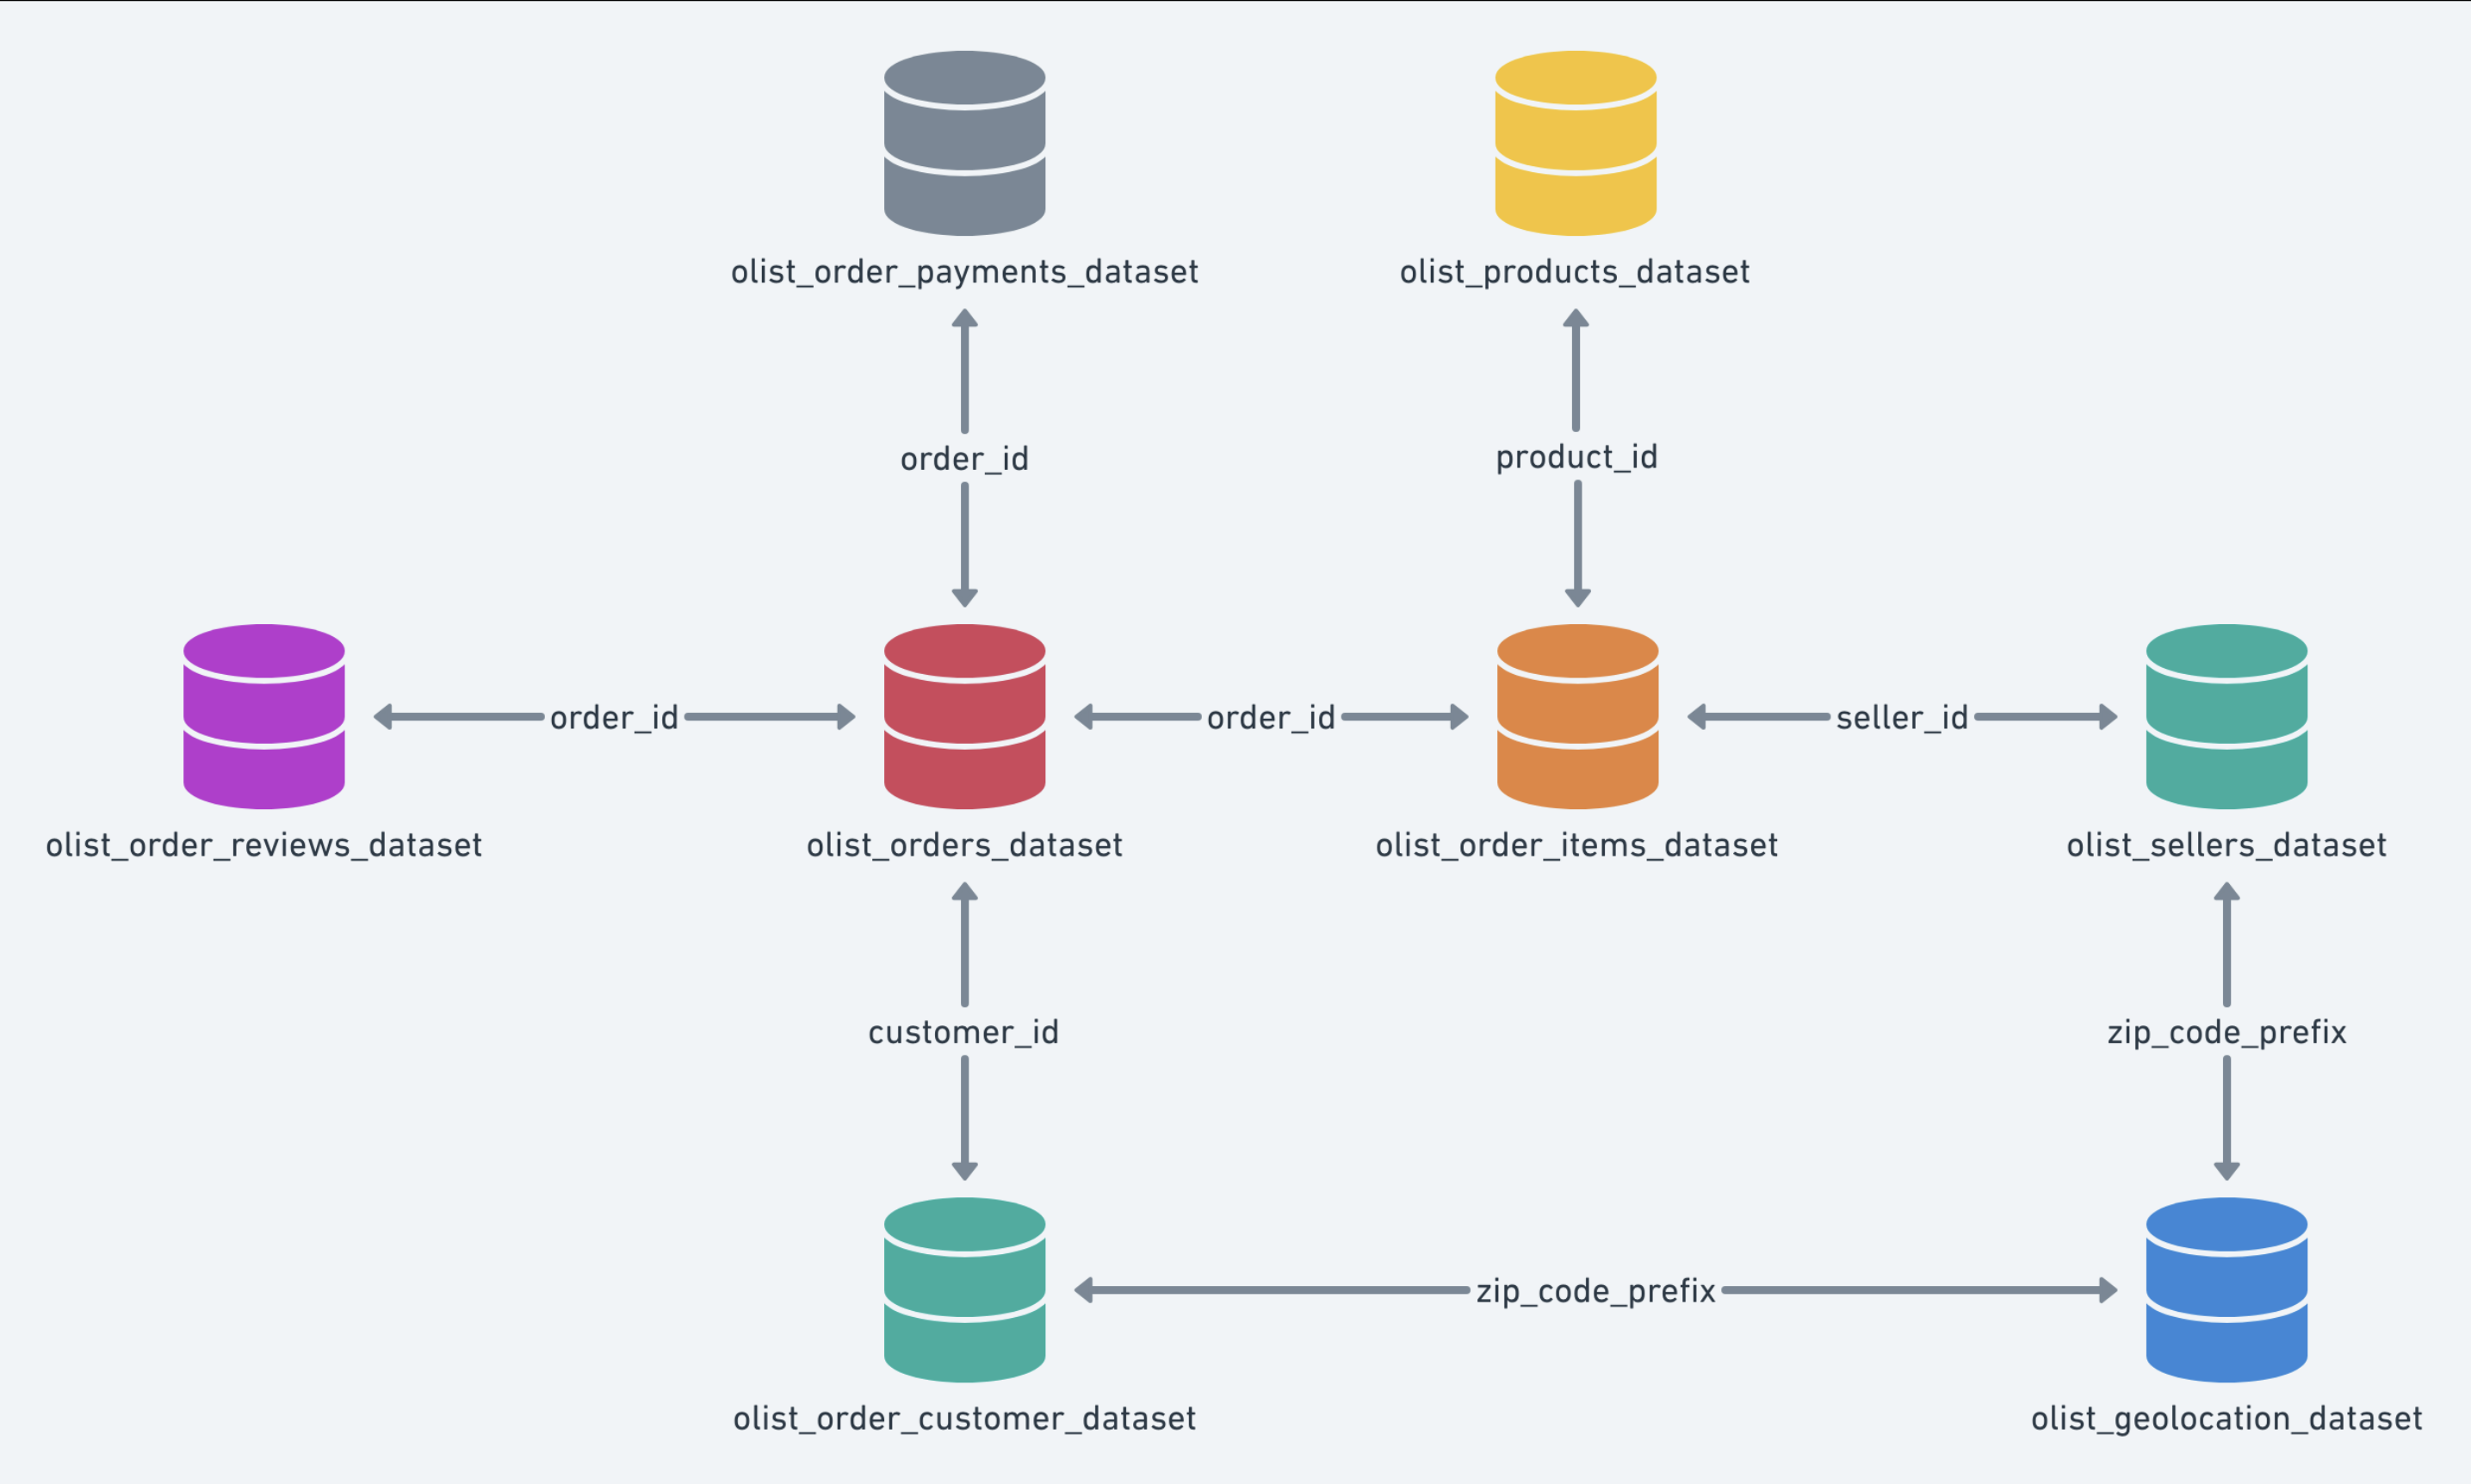 

# Feature ideas:
- difference between purchase and aproved 
- volume of package 
- number of products in order
- kilometers diff (seler - buyer)
- citisize category
# make better prediction than "estimated time"
what is the diff

In [203]:
olist_order_items_dataset

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
...,...,...,...,...,...,...,...
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.0,12.79


In [204]:
olist_products_dataset

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
...,...,...,...,...,...,...,...,...,...
32950,106392145fca363410d287a815be6de4,cama_mesa_banho,58.0,309.0,1.0,2083.0,12.0,2.0,7.0


In [205]:
olist_orders_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
...,...,...,...,...,...,...,...,...
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


In [206]:
olist_products_dataset

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
...,...,...,...,...,...,...,...,...,...
32950,106392145fca363410d287a815be6de4,cama_mesa_banho,58.0,309.0,1.0,2083.0,12.0,2.0,7.0


In [207]:
olist_customers_dataset

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
...,...,...,...,...,...
99440,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP


In [208]:
olist_geolocation_dataset

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
...,...,...,...,...,...
1000162,99950,-28.070104,-52.018658,tapejara,RS


# Joining data


In [209]:
orders_items = pd.merge(
    olist_orders_dataset, olist_order_items_dataset, how="left", on="order_id"
)
orders_items_product = pd.merge(
    orders_items, olist_products_dataset, how="left", on="product_id"
)

orders_items_product_customer = pd.merge(
    orders_items_product, olist_customers_dataset, how="left", on="customer_id"
)

orders_items_product_customer_seller = pd.merge(
    orders_items_product_customer, olist_sellers_dataset, how="left", on="seller_id"
)

In [210]:
df = orders_items_product_customer_seller
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

## Date formatting

In [212]:
datetime_columns = [
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
    "order_purchase_timestamp",
]
df[datetime_columns]

,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,order_purchase_timestamp
0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,2017-10-02 10:56:33
...,...,...,...,...,...,...
113424,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00,2018-03-15 10:55:42,2018-03-08 20:57:30


In [213]:
for col in datetime_columns:
    df.loc[:, col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")

# Target variable

In [214]:
df["target_estimated_delivery_time"] = (
    df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
).apply(lambda x: x.days)

# Kilometers diffrence transformer

In [215]:
class KilometerDiffTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, olist_geolocation_dataset):
        self.olist_geolocation_dataset = olist_geolocation_dataset
        self.city_center_lat = pd.DataFrame()
        self.city_center_lng = pd.DataFrame()

    def fit(self, X, y=None):
        self.city_center_lat = self.olist_geolocation_dataset.groupby(
            by=["geolocation_city", "geolocation_state", "geolocation_zip_code_prefix"],
            as_index=False,
        ).agg(geolocation_lat=("geolocation_lat", "mean"))
        self.city_center_lng = self.olist_geolocation_dataset.groupby(
            by=["geolocation_city", "geolocation_state", "geolocation_zip_code_prefix"],
            as_index=False,
        ).agg(geolocation_lng=("geolocation_lng", "mean"))

        return self

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the distance between two points on the Earth given their latitude and longitude
           in decimal degrees using the Haversine formula.
        """
        # Convert latitude and longitude from decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = 6371 * c  # Earth radius in kilometers

        return distance

    def transform(self, X):
        X_transformed = X.copy()
        city_to_latitude = dict(
            zip(
                self.city_center_lat["geolocation_city"],
                self.city_center_lat["geolocation_lat"],
            )
        )
        X_transformed["customer_city_lat"] = X_transformed["customer_city"].map(
            city_to_latitude
        )
        city_to_longitude = dict(
            zip(
                self.city_center_lng["geolocation_city"],
                self.city_center_lng["geolocation_lng"],
            )
        )

        X_transformed["customer_city_lat"] = X_transformed["customer_city"].map(
            city_to_latitude
        )
        X_transformed["customer_city_lng"] = X_transformed["customer_city"].map(
            city_to_longitude
        )
        X_transformed["seller_city_lat"] = X_transformed["seller_city"].map(
            city_to_latitude
        )
        X_transformed["seller_city_lng"] = X_transformed["seller_city"].map(
            city_to_longitude
        )
        X_transformed["distance_km"] = X_transformed.apply(
            lambda row: self.haversine_distance(
                row["customer_city_lat"],
                row["customer_city_lng"],
                row["seller_city_lat"],
                row["seller_city_lng"],
            ),
            axis=1,
        )

        return X_transformed

In [216]:
pipeline = Pipeline([("km", KilometerDiffTransformer(olist_geolocation_dataset))])
x_trans = pipeline.fit_transform(X=df)

In [217]:
x_trans

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_state,seller_zip_code_prefix,seller_city,seller_state,target_estimated_delivery_time,customer_city_lat,customer_city_lng,seller_city_lat,seller_city_lng,distance_km
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,SP,9350.0,maua,SP,8.0,-23.626929,-46.572773,-23.651066,-46.447235,13.066430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113424,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00,1.0,006619bbed68b000c8ba3f8725d5409e,...,PR,14407.0,franca,SP,7.0,-25.764308,-49.720376,-20.552274,-47.360417,627.716676
